In [171]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
import sys
sys.path.insert(0,'../st_validate')
sys.path.insert(0,'../periodic-kmeans')

import os
import tifffile
import numpy as np
import warnings
import matplotlib.pyplot as plt
np.warnings = warnings # this line is necessary to suppress an error produced by the default np.warnings
import sta_validate # import functions for phantom creation and sta tests
import histology # import functions for computing structure tensors and angles
# import apsym_kmeans # import functions for angle clustering in 3D
import periodic_kmeans # import functions for angle clustering in 2D
import utils

HOME = "/home/brysongray/structure_tensor_validation/"


# Generate a 3D phantom

## Set the phantom parameters

In [176]:
# load presaved angles from file
angles = np.load('../3d_angles.npy')

# choose a random pair of directions from angles
idx = np.random.randint(0,len(angles), size=2)
# true_angles_3d = np.stack((angles[idx[0]], angles[idx[1]]))

# or a single random direction from angles
true_angles_3d = np.array(angles[idx[0]])
print(f'angle: {true_angles_3d}')

# set the image dimensions
shape = (36,72,72)
dI = (shape[1]/shape[0], 1.0, 1.0) # size of pixels along each dimension
x = [np.arange(ni)*di for ni,di in zip(shape,dI)]

# period is the distance between parallel lines in units
# relative to the pixel size along the high resolution dimensions.
period = 10

inverse = False # simulate fluorescence microscopy
# inverse = True # simulate brightfield microscopy

angle: [1.76696101 2.7624534 ]


## Generate the phantom and do anisotropy correction

In [180]:
# generate phantom with anisotropic pixel sizes
image_3d = sta_validate.make_phantom(x, true_angles_3d, period, inverse=inverse, interp=False, blur_correction=False)
# make another phantom with isotropic pixel sizes
image_iso_3d = utils.anisotropy_correction(image_3d, dI=dI)
# make another phantom with blur added to the high resolution dimensions to create equal blur along each dimension
image_iso_blur_3d = utils.anisotropy_correction(image_3d, dI=dI, blur=True)

1.7669610067619275
2.762453398270127


IndexError: invalid index to scalar variable.

## Visualize

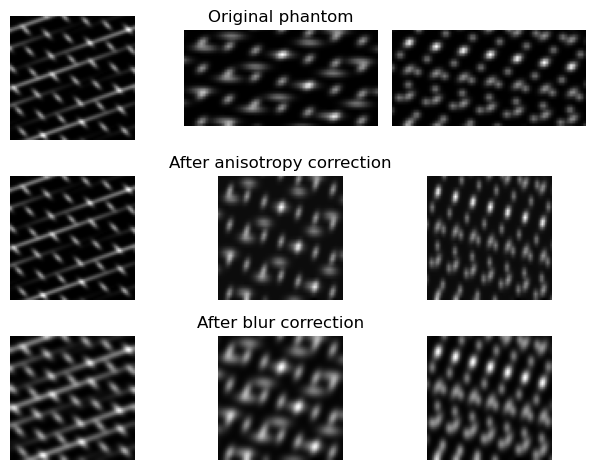

In [160]:
fig, ax = plt.subplots(3,3, tight_layout=True)

ax[0,0].imshow(image_3d[image_3d.shape[0]//2], cmap='gray')
ax[0,1].imshow(image_3d[:, image_3d.shape[1]//2], cmap='gray')
ax[0,1].set_title('Original phantom')
ax[0,2].imshow(image_3d[..., image_3d.shape[2]//2], cmap='gray')
ax[1,0].imshow(image_iso_3d[image_iso_3d.shape[0]//2], cmap='gray')
ax[1,1].imshow(image_iso_3d[:, image_iso_3d.shape[1]//2], cmap='gray')
ax[1,1].set_title('After anisotropy correction')
ax[1,2].imshow(image_iso_3d[..., image_iso_3d.shape[2]//2], cmap='gray')
ax[2,0].imshow(image_iso_blur_3d[image_iso_blur_3d.shape[0]//2], cmap='gray')
ax[2,1].imshow(image_iso_blur_3d[:, image_iso_blur_3d.shape[1]//2], cmap='gray')
ax[2,1].set_title('After blur correction')
ax[2,2].imshow(image_iso_blur_3d[..., image_iso_blur_3d.shape[2]//2], cmap='gray')

for a in ax.flatten():
    a.axis('off')

## Perform structure tensor analysis

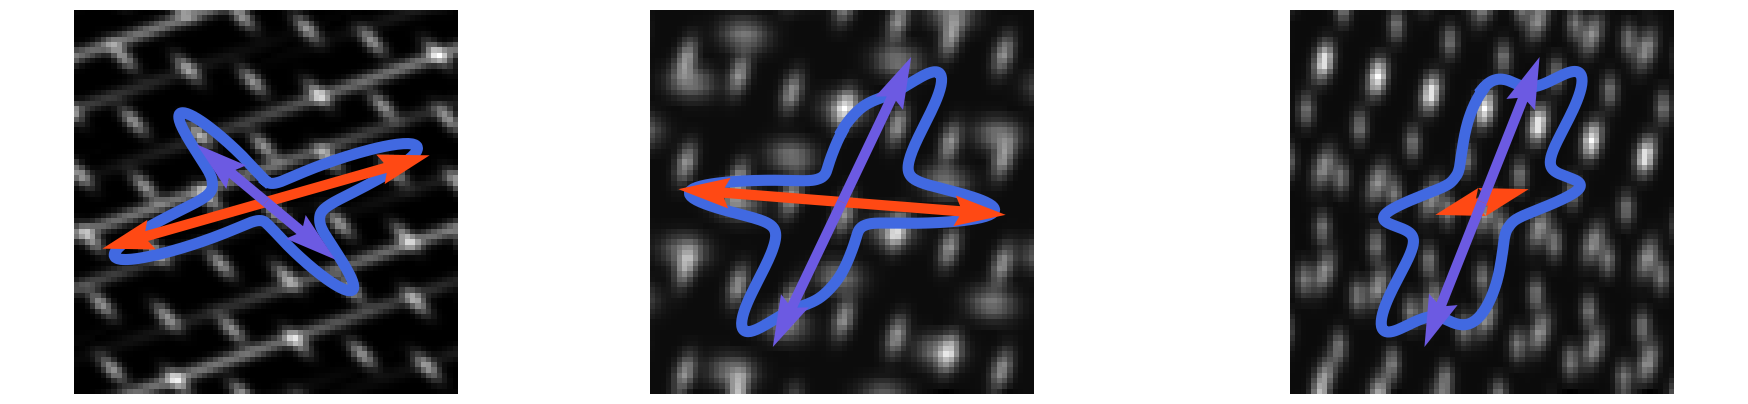

true angles: [[ 0.94297344 -0.32727804  0.06074686]
 [ 0.50613025  0.51184422 -0.69415248]]
estimated angles: [[ 0.95890521 -0.2735516   0.07530147]
 [-0.40544617 -0.33738557  0.84957894]]
mean error (degrees): 8.967342170688143


In [161]:
I = image_iso_3d
sigma_g = 0.5 # gradient standard deviation
sigma_w = 0.5 # window standard deviation

# compute structure tensors given the phantom image and standard deviations
S = histology.structure_tensor(I, derivative_sigma=sigma_g, tensor_sigma=sigma_w)
# compute angles from structure tensors
angles = histology.angles(S, cartesian=True)
angles = angles.reshape(-1,3)

# convert true angles to cartesian coordinates for comparison with estimated angles
true_angles_ = utils.sph_to_cart(true_angles_3d, order='xy')

# Estimate 1 or 2 mean angles from estimated angles using k-means algorithm
if len(true_angles_) == 1:
    means = periodic_kmeans.apsym_kmeans(angles, k=1)
    # difference between estimated mean and true angle (in degrees)
    diff = np.arccos(np.abs(means.dot(true_angles_.T))) * 180/np.pi 

elif len(true_angles_) == 2:
    means = periodic_kmeans.apsym_kmeans(angles, k=2)

    diff = periodic_kmeans.distance_3d(means, true_angles_) # shape (2,2) for two permutations of the difference between two means and two true_thetas
     # get the distance between the closest mean and true angle and the remaining mean and true angle
    diff = periodic_kmeans.multiple_exclusive_distances(diff)
    diff = np.mean(diff) * 180 / np.pi

histology.plot_angles_3d(I, vectors=angles, means=means)
# Note the arrows are colored according to their direction.
# The rgb color components are set to the absolute value of the xyz components:
# x=red, y=green, z=blue.

print(f'true angles: {true_angles_}')
print(f'estimated angles: {means}')
print(f'mean error (degrees): {diff}')

# Generate a 2D phantom

## Set the phantom parameters

In [162]:
# Choose two angles
true_angles_2d = [np.pi/3, 0.0]

# or one angle
# true_angles_2d = [np.pi/4]

# set the image dimensions
shape = (96,96)
dI = (shape[1]/shape[0], 1.0)
x = [np.arange(ni)*di for ni,di in zip(shape,dI)]

# set the period (distance between parallel lines)
period = 10

inverse = False # simulate fluorescence microscopy
# inverse = True # simulate brightfield microscopy

## Generate the phantom and do anisotropy correction

In [163]:
# generate phantom with anisotropic pixel sizes
image_2d = sta_validate.make_phantom(x, true_angles_2d, period, inverse=inverse, interp=False, blur_correction=False)
# make another phantom with isotropic pixel sizes
image_iso_2d = utils.anisotropy_correction(image_2d, dI=dI)
# make another phantom with blur added to the high resolution dimensions to create equal blur along each dimension
image_iso_blur_2d = utils.anisotropy_correction(image_2d, dI=dI, blur=True)

## Visualize

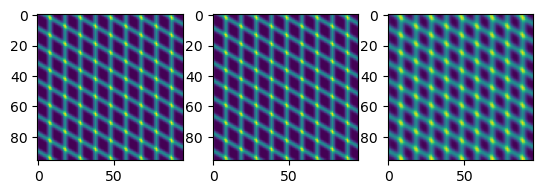

In [164]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(image_2d)
ax[1].imshow(image_iso_2d)
ax[2].imshow(image_iso_blur_2d)

# Perform structure tensor analysis on a 2D phantom

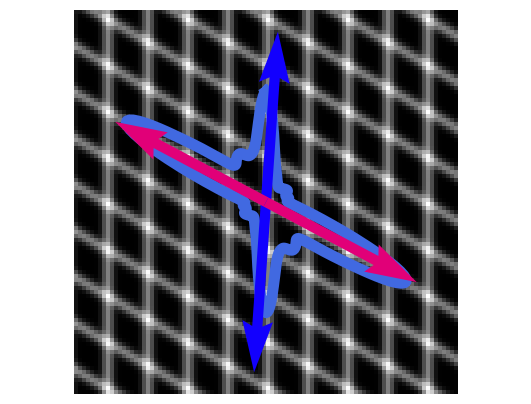

true angles: [1.0471975511965976, 0.0]
estimated angles: [3.07177948 1.08210414]
mean error (degrees): 3.000000000000004


In [165]:
I = image_iso_2d
sigma_g = 0.5 # gradient standard deviation
sigma_w = 0.0 # window standard deviation

# compute structure tensors given the phantom image and standard deviations
S = histology.structure_tensor(I, derivative_sigma=sigma_g, tensor_sigma=sigma_w)
# compute angles from structure tensors
angles = histology.angles(S)
angles = angles.flatten()#[..., None]
angles = np.where(angles < 0, angles + np.pi, angles) # flip angles to be in the range [0,pi] for periodic kmeans

# Estimate 1 or 2 mean angles from estimated angles using k-means algorithm
if len(true_angles_2d) == 1:
    x = np.arange(180) * np.pi/180
    means = periodic_kmeans.periodic_mean(angles.flatten(), x, period=np.pi)[None]
elif len(true_angles_2d) == 2:
    means = periodic_kmeans.periodic_kmeans(angles.flatten(), period=np.pi, k=2)

mean_colors = np.abs([np.sin(means), np.zeros(len(means)), np.cos(means)]).T

histology.plot_angles(I, angles=angles, means=means, mean_colors=mean_colors)
# Note the arrows are colored according to their directions.
print(f'true angles: {true_angles_2d}')
print(f'estimated angles: {means}')

diff = periodic_kmeans.distance(means, np.array(true_angles_2d), period=np.pi)
diff = diff.min(0) * 180/np.pi
error = np.mean(diff)

print(f'mean error (degrees): {error}')

## Compute ST analysis error in one line using sta_test

In [166]:
error = sta_validate.sta_test(image_iso_2d, derivative_sigma=sigma_g, tensor_sigma=sigma_w, true_thetas=true_angles_2d)
print(error)

3.0000000000000044


In [167]:
error = sta_validate.sta_test(image_iso_3d, derivative_sigma=sigma_g, tensor_sigma=sigma_w, true_thetas=true_angles_3d)
print(error)

24.43001208052261


## Run ST analysis tests on a series of phantoms

In [143]:
# Set lists for each parameter to use for generating phantoms and computing structure tensors
derivative_sigmas = np.linspace(start=0.5, stop=1.5, num=3) # standard deviations of first derivative filter
tensor_sigmas = np.linspace(start=1.0, stop=3.0, num=3) # standard devations of window averaging filter
nIs = [(96,96), (48,96), (32,96)] # Phantom shapes (number of pixels along each dimension)
periods=[10] # spacing between lines. 1 unit is equal to the size of a pixel in the high resolutin dimension.
angles=[[np.pi/3,-np.pi/6], [np.pi/3, 0.0], [np.pi/3, np.pi/6]] # List of pairs angles to use for phantom lines.

# Generate and test structure tensor analysis for each permutation of the parameters defined above.
error_df = sta_validate.run_tests(derivative_sigmas=derivative_sigmas, tensor_sigmas=tensor_sigmas, nIs=nIs, periods=periods, angles=angles)

# The result is a pandas dataframe where each row is a structure tensor analysis test,
# and the parameters used for the test are in the columns.
# The last column is the resultant error using the given parameters.
print(error_df[:12])

  0%|          | 0/9 [00:00<?, ?it/s]

    derivative_sigma  tensor_sigma  anisotropy_ratio  period  \
0                0.5           1.0               1.0    10.0   
1                0.5           2.0               1.0    10.0   
2                0.5           3.0               1.0    10.0   
3                1.0           1.0               1.0    10.0   
4                1.0           2.0               1.0    10.0   
5                1.0           3.0               1.0    10.0   
6                1.5           1.0               1.0    10.0   
7                1.5           2.0               1.0    10.0   
8                1.5           3.0               1.0    10.0   
9                0.5           1.0               1.0    10.0   
10               0.5           2.0               1.0    10.0   
11               0.5           3.0               1.0    10.0   

                                       angles         error  
0   [1.0471975511965976, -0.5235987755982988]  6.361109e-15  
1   [1.0471975511965976, -0.523598775598298

In [223]:
# file = "/home/brysongray/fibermetric/outputs/sta_validate_outputs/phantoms/phantoms-72-iso-blur/phantom_AI-1.00_period-07_theta-0.11_phi-1.35.npz"
file = "/home/brysongray/fibermetric/outputs/sta_validate_outputs/phantoms/phantoms-72-iso-blur/phantom_AI-1.00_period-07_theta-0.31-0.82_phi-0.20-2.38.npz"
# file = "/home/brysongray/bmap/bryson/fibermetric/st_validation/phantoms_2d-96/phantom_AI-1.00_period-07_theta-0.00.npz"
# file = "/home/brysongray/bmap/bryson/fibermetric/st_validation/phantoms_2d-96/phantom_AI-1.00_period-07_theta-0.00-0.48.npz"
npz = np.load(file)
phantom = npz['image']
AI = npz['AI']
period = npz['period']
angle = npz['angle']

print(angle)
print(angle.ndim)
print(len(angle))
# isinstance(angle, np.ndarray)

[[0.30909004 0.1999612 ]
 [0.81687111 2.37564952]]
2
2


In [212]:
x = np.array(1.0)
x.ndim

0

In [197]:
import pandas as pd
import tqdm

In [225]:
# path = "/home/brysongray/bmap/bryson/fibermetric/st_validation/phantoms_2d-96/phantom_AI-1.00_period-07_theta-0.00.npz"
# path = "/home/brysongray/bmap/bryson/fibermetric/st_validation/phantoms_2d-96/phantom_AI-1.00_period-07_theta-0.00-0.48.npz"
# path = "/home/brysongray/fibermetric/outputs/sta_validate_outputs/phantoms/phantoms-72-iso-blur/phantom_AI-1.00_period-07_theta-0.11_phi-1.35.npz"
path = "/home/brysongray/fibermetric/outputs/sta_validate_outputs/phantoms/phantoms-72-iso-blur/phantom_AI-1.00_period-07_theta-0.31-0.82_phi-0.20-2.38.npz"


out = "test"

if os.path.isdir(path):
    files = [os.path.join(path, f) for f in os.listdir(path)]
else:
    files = [path]

for file in tqdm.tqdm(files):
    npz = np.load(file)
    phantom = npz['image']
    AI = npz['AI']
    period = npz['period']
    angle = npz['angle']

    # save dataframe using pickle
    if phantom.ndim == 2:
        if angle.ndim == 0:
            name = f'error_AI-{AI:.2f}_period-{period:02d}_theta-{angle:.2f}.p'
        else:
            name = f'error_AI-{AI:.2f}_period-{period:02d}_theta-{angle[0]:.2f}-{angle[1]:.2f}.p'

    if phantom.ndim == 3:
        if angle.ndim == 1:
                name = f'error_AI-{AI:.2f}_period-{period:02d}_theta-{angle[0]:.2f}_phi-{angle[1]:.2f}.p'
        else:
            name = f'error_AI-{AI:.2f}_period-{period:02d}_theta-{angle[0,0]:.2f}-{angle[1,0]:.2f}_phi-{angle[0,1]:.2f}-{angle[1,1]:.2f}.p'
    
    if os.path.exists(os.path.join(out,name)):
        continue

    error_df = pd.DataFrame({'derivative_sigma':[], 'tensor_sigma':[], 'AI':[], 'period':[],
                            'width':[], 'angles':[], 'error':[]})

    for sigma0 in derivative_sigmas:
        for sigma1 in tensor_sigmas:
            crop_all = round(max(sigma0,sigma1)*8/3) # two-thirds the radius of the largest kernel
            crop_end = round(float(AI)) - 1
            error = sta_validate.sta_test(phantom, sigma0, sigma1, true_thetas=angle, crop=crop_all, crop_end=crop_end)
            new_row = {'derivative_sigma': sigma0, 'tensor_sigma': sigma1,
                        'AI': AI, 'period': period, 'width': 1,
                        'angles': [angle], 'error': error
                    }
            error_df = pd.concat((error_df, pd.DataFrame(new_row)), ignore_index=True)

    
    # print(f'saving {name} to {out}')

    # with open(os.path.join(out,name), 'wb') as f:
    #     pickle.dump(error_df, f)
    

100%|██████████| 1/1 [00:17<00:00, 17.57s/it]
